In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
from matplotlib.colors import Normalize
import time
from math import *
import sys
import pandas as pd


import scipy
from scipy import io
import ast

import torch
import torch.nn as nn
import torch.optim as optim

import sys
sys.path.append('../')  # Ensure the module path is accessible

# Reload the updated module
import importlib
import pinns  # Import the module
importlib.reload(pinns)

# Import the updated PINNs class
from pinns import PINNs


cmap = plt.get_cmap('inferno')
cmap2 = plt.get_cmap('seismic')

import seaborn as sns

# Define a discrete color palette with a specified number of colors
#sns.set_palette(sns.color_palette("muted", n_colors=10))  # or use another color map and adjust `n_colors`
custom_palette = ["#FFB347", "#779ECB", "#77DD77", "#FF6961", "royalblue", "#CB99C9", "#FDFD96", "#AEC6CF"]
costum_palette_pairs = ['#ffb347', '#ffcc84', '#ffe6c2', 
                        '#779ecb', '#a4bedc', '#d2dfee', 
                        '#77dd77', '#a4e8a4', '#d2f4d2', 
                        '#ff6961', '#ff9b96', '#ffcdca', 
                        '#cb99c9', '#dcbbdb', '#eedded', 
                        '#fdfd96', '#fefeb9', '#fefedc',
                        '#aec6cf', '#c9d9df', '#e4ecef']

sns.set_palette(custom_palette)
colors = sns.color_palette()
colors_pairs = sns.color_palette(costum_palette_pairs) #("tab20c")

cmap1 = plt.get_cmap('inferno')
cmap2 = plt.get_cmap('viridis')
cmap3 = plt.get_cmap('binary') #('seismic')

# set title font size
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Load data: CylinderFlow, single frame

In [2]:
# Load data
df = pd.read_csv(f'CylinderFlowData.csv')

# Extract number of nodes
N_nodes = int(df['ptr'].iloc[2])

# Cut data to N_nodes
df = df.head(N_nodes)

# Extract data
x_data = df['x'].apply(ast.literal_eval) 
y_data = df['y'].apply(ast.literal_eval) 
pos = df['pos'].apply(ast.literal_eval)
batch = df['batch']
ptr = df['ptr'].head(3)
edge_index = df['edge_index'].head(2)
edge_attr = df['edge_attr']
dt = abs(x_data.iloc[0][-1] - x_data.iloc[-1][-1])

In [3]:
# Create data frame with extracted data
data = pd.DataFrame({
    'node_type': x_data.apply(lambda x: x[0] if len(x) > 0 else None),  # Node type
    'pos_x': pos.apply(lambda x: x[0] if len(x) > 0 else None),         # Position x
    'pos_y': pos.apply(lambda x: x[1] if len(x) > 1 else None),         # Position y
    'vx': y_data.apply(lambda x: x[0] if len(x) > 0 else None),         # Velocity x
    'vy': y_data.apply(lambda x: x[1] if len(x) > 1 else None),         # Velocity y
    'p': x_data.apply(lambda x: x[3] if len(x) > 0 else None),          # Pressure
    't' : x_data.apply(lambda x: x[4] if len(x) > 0 else None),         # Time
})


# Split data into two time steps (obs: t2 is the first half of the data)
data_t1 = data.iloc[int(N_nodes/2):].reset_index(drop=True)
data_t2 = data.iloc[0:int(N_nodes/2)].reset_index(drop=True)

# See node types
data['node_type'].value_counts()

0.0    3284
6.0     400
4.0      34
5.0      34
Name: node_type, dtype: int64

# Plot data

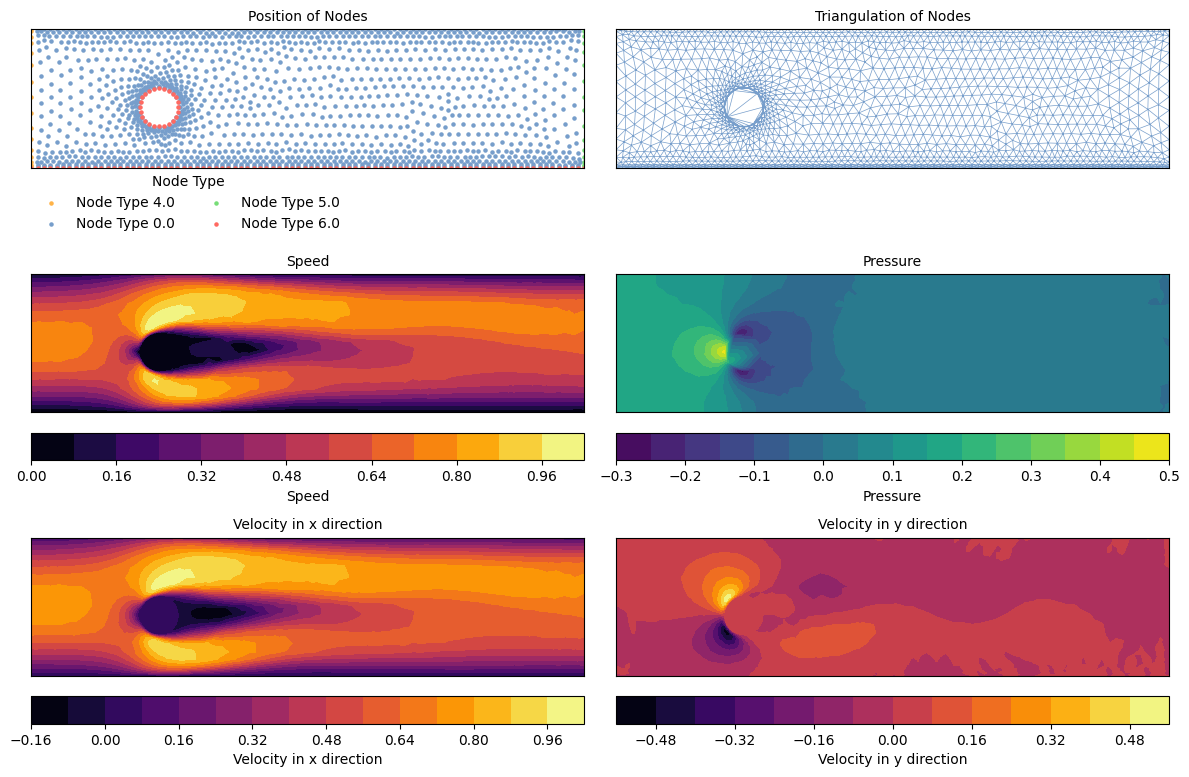

In [42]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
from matplotlib.colors import Normalize

# Create the figure and axes (2 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Common settings for all axes
for ax in axes:
    ax.set_xlim(0, 1.6)
    ax.set_ylim(0, 0.4)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])


# Position and type of nodes
unique_node_types = data_t1['node_type'].unique()

axes[0].set_title('Position of Nodes')
for node_type, color in zip(unique_node_types, colors):
    df_type = data_t1[data_t1['node_type'] == node_type]
    axes[0].scatter(df_type['pos_x'], df_type['pos_y'], s=5, label=f"Node Type {node_type}", color=color)
axes[0].legend(loc=[0.0, -0.5], frameon=False, title='Node Type', ncols=2)

# Triangulation of nodes
axes[1].set_title('Triangulation of Nodes')
triang = tri.Triangulation(data_t1['pos_x'], data_t1['pos_y'])
axes[1].triplot(triang, '-', lw=0.5, color=colors[1])

# Velocity at nodes
axes[2].set_title('Speed')
velocity_ref = np.sqrt(data_t1['vx']**2 + data_t1['vy']**2)
contour_velocity = axes[2].tricontourf(triang, velocity_ref, levels=14, cmap=cmap1)

# Pressure at nodes
axes[3].set_title('Pressure')
contour_pressure = axes[3].tricontourf(triang, data_t1['p'], levels=14, cmap=cmap2)

# Add colorbars below the velocity and pressure plots
fig.subplots_adjust(bottom=0.2)  # Adjust the figure to make space for colorbars

# Create colorbars
cbar_velocity = fig.colorbar(contour_velocity, ax=axes[2], orientation='horizontal', pad=0.1, label='Speed')
cbar_pressure = fig.colorbar(contour_pressure, ax=axes[3], orientation='horizontal', pad=0.1, label='Pressure')

# Plot velocity in x direction
axes[4].set_title('Velocity in x direction')
contour_vx = axes[4].tricontourf(triang, data_t1['vx'], levels=14, cmap=cmap1)

# Plot velocity in y direction
axes[5].set_title('Velocity in y direction')
contour_vy = axes[5].tricontourf(triang, data_t1['vy'], levels=14, cmap=cmap1)

# Create colorbars below the velocity in x and y direction plots
fig.subplots_adjust(bottom=0.2)  # Adjust the figure to make space for colorbars

# Create colorbars
cbar_vx = fig.colorbar(contour_vx, ax=axes[4], orientation='horizontal', pad=0.1, label='Velocity in x direction')
cbar_vy = fig.colorbar(contour_vy, ax=axes[5], orientation='horizontal', pad=0.1, label='Velocity in y direction')


# Show the plot
plt.tight_layout()
plt.show()


# Define and plot training data

Shape of X_star:  torch.Size([1876, 3])
Shape of X_colloc:  torch.Size([200, 3])
Shape of X_supervised:  torch.Size([200, 3])
Shape of X_val:  torch.Size([0, 3])


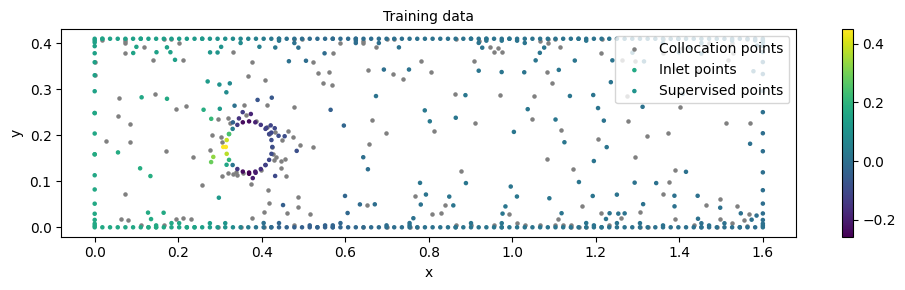

In [83]:
X_star = torch.tensor(data_t1[['pos_x', 'pos_y', 't']].values, dtype=torch.float64, requires_grad=True)
y_star = torch.tensor(data_t1[['vx', 'vy', 'p']].values, dtype=torch.float64)
print("Shape of X_star: ", X_star.shape)

# Total number of points
total_points = X_star.shape[0]

# Specify sizes for each dataset
N_input = 200       # Number of training collocation points
N_supervised = 200   # Number of supervised data points
N_val = 0          # Number of validation data points

# Ensure the sum of the dataset sizes doesn't exceed the total number of points
assert N_input + N_supervised + N_val <= total_points, "Dataset sizes exceed the total number of available points."

# Shuffle all indices
all_indices = np.arange(total_points)
np.random.shuffle(all_indices)

# Split the indices into disjoint subsets
idx_input = all_indices[:N_input]
idx_supervised = all_indices[N_input:N_input + N_supervised]
idx_val = all_indices[N_input + N_supervised:N_input + N_supervised + N_val]

# Create training collocation data
X_colloc = X_star[idx_input]
y_colloc = y_star[idx_input]
print("Shape of X_colloc: ", X_colloc.shape)

# Create supervised data
X_supervised = X_star[idx_supervised]
y_supervised = y_star[idx_supervised]
print("Shape of X_supervised: ", X_supervised.shape)

# Create validation data
X_val = X_star[idx_val]
y_val = y_star[idx_val]
print("Shape of X_val: ", X_val.shape)

# Inlet and outlet data (supervised for a unique solution) for node_type == 4.0 and node_type == 5.0
X_boundary = torch.tensor(data_t1[data_t1['node_type'].isin([4.0, 5.0, 6.0])][['pos_x', 'pos_y', 't']].values, dtype=torch.float64, requires_grad=True)
y_boundary = torch.tensor(data_t1[data_t1['node_type'].isin([4.0, 5.0, 6.0])][['vx', 'vy', 'p']].values, dtype=torch.float64)

# Plot training data
fig = plt.figure(figsize=(10, 3))
plt.scatter(X_colloc[:, 0].detach().numpy(), X_colloc[:, 1].detach().numpy(), s=5, c='grey', label='Collocation points')
plt.scatter(X_boundary[:, 0].detach().numpy(), X_boundary[:, 1].detach().numpy(), s=5, c=y_boundary[:, -1].detach().numpy(), cmap='viridis', label='Inlet points')
plt.scatter(X_supervised[:, 0].detach().numpy(), X_supervised[:, 1].detach().numpy(), s=5, c=y_supervised[:, -1].detach().numpy(), cmap='viridis', label='Supervised points')
plt.title('Training data')

plt.legend(loc='upper right', frameon=True)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()

plt.tight_layout()
plt.show()


# Define PDEs

In [84]:
def net_transform(X_f, model_nn):
    return model_nn(X_f)


def f_user(X_f, model_nn, Re=10000):
    # Extract x, y, t from the input tensor
    x_temp = X_f[:, 0:1]
    y_temp = X_f[:, 1:2]
    t_temp = X_f[:, 2:3]

    # Ensure gradients are enabled for these variables
    x_temp.requires_grad = True
    y_temp.requires_grad = True
    t_temp.requires_grad = True


    # Model predictions
    X_temp = torch.cat([x_temp, y_temp, t_temp], dim=1)
    pred = model_nn(X_temp)
    
    # Outputs: momentum components (w_x, w_y) and pressure (p)
    w_x = pred[:, 0:1]
    w_y = pred[:, 1:2]
    p = pred[:, 2:3]

    # First-order derivatives
    w_x_t = torch.autograd.grad(w_x, t_temp, grad_outputs=torch.ones_like(w_x), create_graph=True)[0]
    w_y_t = torch.autograd.grad(w_y, t_temp, grad_outputs=torch.ones_like(w_y), create_graph=True)[0]

    w_x_x = torch.autograd.grad(w_x, x_temp, grad_outputs=torch.ones_like(w_x), create_graph=True)[0]
    w_y_x = torch.autograd.grad(w_y, x_temp, grad_outputs=torch.ones_like(w_y), create_graph=True)[0]
    p_x = torch.autograd.grad(p, x_temp, grad_outputs=torch.ones_like(p), create_graph=True)[0]

    w_x_y = torch.autograd.grad(w_x, y_temp, grad_outputs=torch.ones_like(w_x), create_graph=True)[0]
    w_y_y = torch.autograd.grad(w_y, y_temp, grad_outputs=torch.ones_like(w_y), create_graph=True)[0]
    p_y = torch.autograd.grad(p, y_temp, grad_outputs=torch.ones_like(p), create_graph=True)[0]

    # Second-order derivatives
    w_x_xx = torch.autograd.grad(w_x_x, x_temp, grad_outputs=torch.ones_like(w_x_x), create_graph=True)[0]
    w_y_xx = torch.autograd.grad(w_y_x, x_temp, grad_outputs=torch.ones_like(w_y_x), create_graph=True)[0]

    w_x_yy = torch.autograd.grad(w_x_y, y_temp, grad_outputs=torch.ones_like(w_x_y), create_graph=True)[0]
    w_y_yy = torch.autograd.grad(w_y_y, y_temp, grad_outputs=torch.ones_like(w_y_y), create_graph=True)[0]

    # Navier-Stokes momentum equations
    f_1 = w_x_t + w_x * w_x_x + w_y * w_x_y - 1.0 / Re * (w_x_xx + w_x_yy) + p_x
    f_2 = w_y_t + w_x * w_y_x + w_y * w_y_y - 1.0 / Re * (w_y_xx + w_y_yy) + p_y

    # Continuity equation (incompressibility constraint)
    f_3 = w_x_x + w_y_y

    return f_1, f_2, f_3

def loss_f(f, weights=[1.0, 1.0, 1.0]):
    return weights[0] * torch.mean(f[0]**2) + weights[1] * torch.mean(f[1]**2) + weights[2] * torch.mean(f[2]**2)

# Define model and train

In [85]:
# Depth and width of the neural networks
layers = [3] + 4*[64] + [3]

# Learning rate for Adam optimizer
lr = 0.01

In [91]:
model_pinn = PINNs(X_colloc, 
             net_transform, 
             f_user, 
             loss_f,
             layers, 
             lr,
             type_problem='forward',
             X_data=X_supervised, 
             u_data=y_supervised, 
             X_bc=X_boundary, 
             u_bc=y_boundary,
             X_test=X_val,
             u_test=y_val)

model_pinn.net_u = model_pinn.net_u.double()
model_pinn.train(max_epochs_adam=0, max_epochs_lbfgs=200000, print_per_epochs=100)

/Users/sophiawilson/Documents/MScThesis/InitialExperiments/Experiment4/pinns.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_bc = torch.tensor(X_bc, dtype=torch.float64)
/Users/sophiawilson/Documents/MScThesis/InitialExperiments/Experiment4/pinns.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u_bc = torch.tensor(u_bc, dtype=torch.float64)
/Users/sophiawilson/Documents/MScThesis/InitialExperiments/Experiment4/pinns.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_data = torch.tensor(X_data, dtype=torch.flo

No data at the initial instant
No other condition is provided
Loss at epoch 0 (L-BFGS): 0.4381443216067564
Loss at epoch 100 (L-BFGS): 0.15171914963052077
Loss at epoch 200 (L-BFGS): 0.09135834196044912
Loss at epoch 300 (L-BFGS): 0.05922278790459445
Loss at epoch 400 (L-BFGS): 0.055844055395309025
Loss at epoch 500 (L-BFGS): 0.05356468308691149
Loss at epoch 600 (L-BFGS): 0.05091809924219267
Loss at epoch 700 (L-BFGS): 0.04832238855019346
Loss at epoch 800 (L-BFGS): 0.04559982479097071
Loss at epoch 900 (L-BFGS): 0.04274981943177468
Loss at epoch 1000 (L-BFGS): 0.040411385689634156
Loss at epoch 1100 (L-BFGS): 0.03841829867152644
Loss at epoch 1200 (L-BFGS): 0.036750277751371255
Loss at epoch 1300 (L-BFGS): 0.03499442580785292
Loss at epoch 1400 (L-BFGS): 0.03371679042322036
Loss at epoch 1500 (L-BFGS): 0.03264885780638694
Loss at epoch 1600 (L-BFGS): 0.03156015129739076
Loss at epoch 1700 (L-BFGS): 0.030174609517455975
Loss at epoch 1800 (L-BFGS): 0.02896087188788354
Loss at epoch 19

# Plot training loss

In [92]:
print(model_pinn.X_test.shape)
print(model_pinn.u_test.shape)

torch.Size([0, 3])
torch.Size([0, 3])


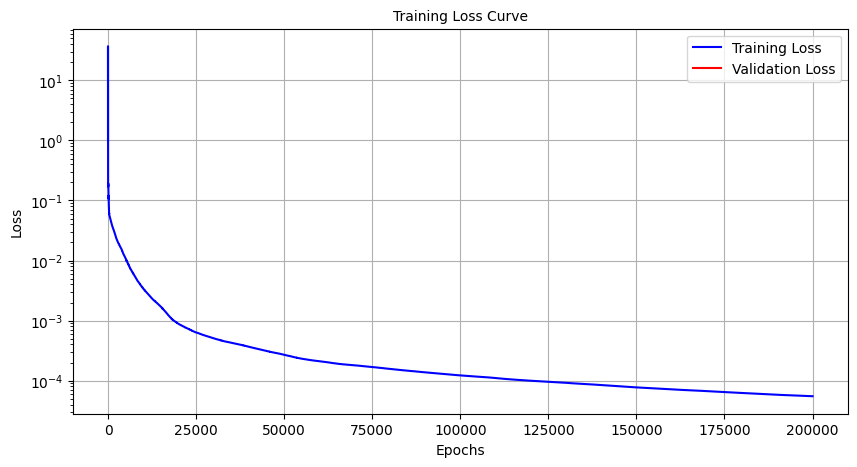

In [93]:
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(model_pinn.loss_array, label='Training Loss', color='blue')
plt.plot(model_pinn.test_array, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

# Plot results

In [94]:
with torch.no_grad():  # Disable gradient computation for inference
    pred = model_pinn.net_u(X_star).detach().numpy()

/var/folders/5c/kvpjh5n11_j2mp3l99c22xdr0000gn/T/ipykernel_69616/2522469474.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


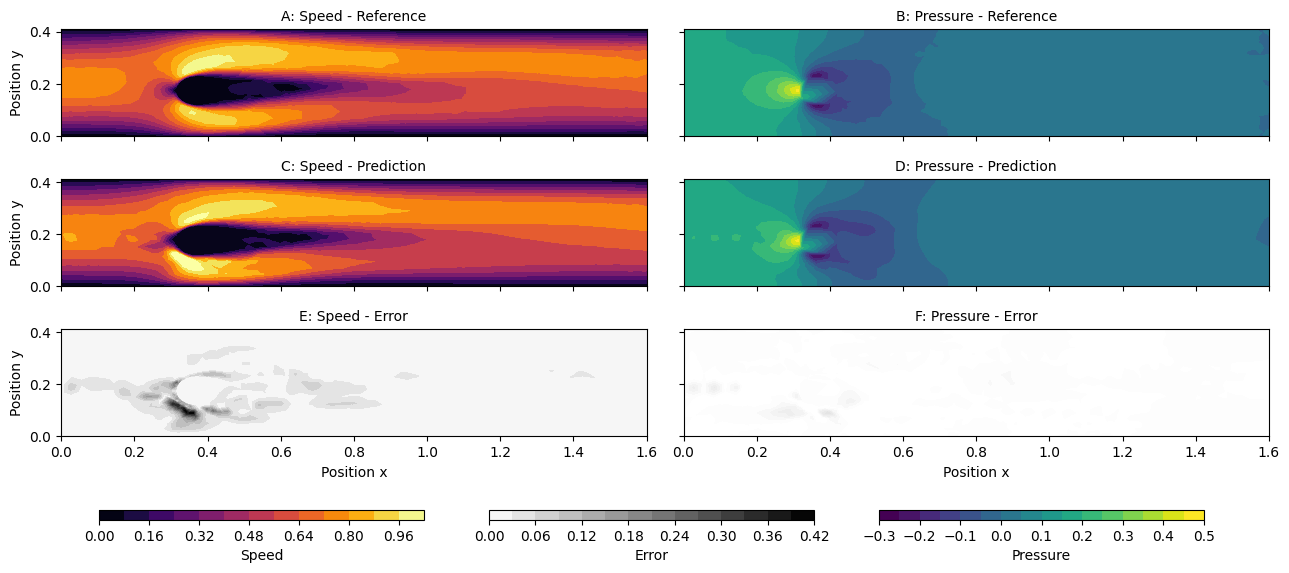

Mean squared error:  0.0005303922155376042


In [95]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
from matplotlib.colors import Normalize

# Compute the velocity magnitudes for reference, prediction, and error
velocity_ref = np.sqrt(data_t1['vx']**2 + data_t1['vy']**2)
velocity_pred = np.sqrt(pred[:, 0]**2 + pred[:, 1]**2)
velocity_error = np.sqrt((pred[:, 0] - data_t1['vx'])**2 + (pred[:, 1] - data_t1['vy'])**2)

# Create triangulation for positions
triang = tri.Triangulation(data_t1['pos_x'], data_t1['pos_y'])

# Speed values
vmin_speed, vmax_speed = velocity_ref.min(), velocity_ref.max()

# Pressure values
vmin_pres, vmax_pres = data_t1['p'].min(), data_t1['p'].max()

# Error values (min and max for both speed and pressure)
vmin_error = np.min([velocity_error.min(), pred[:, 2].min() - data_t1['p'].min()])
vmax_error = np.max([velocity_error.max(), pred[:, 2].max() - data_t1['p'].max()])

# Create the figure and axes (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(13, 5), sharex=True, sharey=True)

# Plot Velocity Magnitude - Reference
axes[0, 0].set_title('A: Speed - Reference')
contour_ref = axes[0, 0].tricontourf(triang, velocity_ref, levels=14, cmap=cmap1, norm=Normalize(vmin=vmin_speed, vmax=vmax_speed))

# Plot Velocity Magnitude - Prediction
axes[1, 0].set_title('C: Speed - Prediction')
contour_pred = axes[1, 0].tricontourf(triang, velocity_pred, levels=14, cmap=cmap1, norm=Normalize(vmin=vmin_speed, vmax=vmax_speed))

# Plot Velocity Magnitude - Error
axes[2, 0].set_title('E: Speed - Error')
contour_err = axes[2, 0].tricontourf(triang, velocity_error, levels=14, cmap=cmap3, norm=Normalize(vmin=vmin_error, vmax=vmax_error))

# Plot Pressure - Reference
axes[0, 1].set_title('B: Pressure - Reference')
pressure_contour_ref = axes[0, 1].tricontourf(triang, data_t1['p'], levels=14, cmap=cmap2, norm=Normalize(vmin=vmin_pres, vmax=vmax_pres))

# Plot Pressure - Prediction
axes[1, 1].set_title('D: Pressure - Prediction')
pressure_contour_pred = axes[1, 1].tricontourf(triang, pred[:, 2], levels=14, cmap=cmap2, norm=Normalize(vmin=vmin_pres, vmax=vmax_pres))

# Plot Pressure - Error
axes[2, 1].set_title('F: Pressure - Error')
pressure_contour_error = axes[2, 1].tricontourf(triang, pred[:, 2] - data_t1['p'], levels=14, cmap=cmap3, norm=Normalize(vmin=vmin_error, vmax=vmax_error))

# Add labels to the axes
for ax in axes[:, 0]:
    ax.set_ylabel('Position y')
for ax in axes[2, :]:
    ax.set_xlabel('Position x')

# Adjust the figure to make space for the colorbars
fig.subplots_adjust(bottom=0.15)

# Add colorbars below the plots
cbar_ax1 = fig.add_axes([0.08, -0.05, 0.25, 0.02])  # Position for speed colorbar
cbar_ax2 = fig.add_axes([0.38, -0.05, 0.25, 0.02])  # Position for pressure colorbar
cbar_ax3 = fig.add_axes([0.68, -0.05, 0.25, 0.02])  # Position for error colorbar

# Create the colorbars
fig.colorbar(contour_ref, cax=cbar_ax1, orientation='horizontal', label='Speed')
fig.colorbar(contour_err, cax=cbar_ax2, orientation='horizontal', label='Error')
fig.colorbar(pressure_contour_ref, cax=cbar_ax3, orientation='horizontal', label='Pressure')


# Display the plot
plt.tight_layout()
plt.show()

# Print mean squared error
mse = np.mean((pred - data_t1[['vx', 'vy', 'p']].values) ** 2)
print("Mean squared error: ", mse)

| **Run** | **Re** | **Supervised Data** | **Non-supervised Data** | **Adam Epochs** | **LBFGS Epochs** | **MSE**                 | **Other notes** |
|----------|---------|--------------------|-------------------------|-----------------|------------------|-------------------------| ---------------|
| Run1     | 100     | 200                | 200                     | 1000            | 10,000           | 0.0021865961087846743   |                |
| Run2     | 100     | 200                | 200                     | 0               | 20,000           | 0.0015767077514754232   |                |    
| Run3     | 100     | 200                | 500                     | 0               | 20,000           | 0.0019579177616458575   |                |
| Run4     | 100     | 200                | 1                       | 0               | 20,000           | 0.0015350067773793167   |                |
| Run5     | 3000    | 200                | 200                     | 0               | 20,000           | 0.0017683036853817595   |                |                
| Run6     | 3000    | 200                | 200                     | 0               | 40,000           | 0.0007774736313961177   |                |   
| Run7     | 3000    | 200                | 200                     | 0               | 40,000           | 0.00036712908884482234  | Enture boundary included from here on|
| Run8     | 3000    | 400                | 1                       | 0               | 40,000           | 0.00015852247854442547  | |
| Run9     | 3000    | 0                | 400                       | 0               | 40,000           | 0.06675485685136609     | Predictions very bad |
| Run10     | 3000    | 0                | 1876                       | 0               | 40,000           | 0.06675485685136609     | Used all nodes for physics training points. Same result as before |